In [1]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import os
os.chdir("drive/My Drive/Competitions/Assignment5")

#!unzip -q "./hvc_data.zip"
# look for `hvc_annotations.csv` file and `resized` dir
%ls 

'Copy_4 of PersonAttrubutes.ipynb'           hvc_data.zip   saved_models/
'Copy of Copy_4 of PersonAttrubutes.ipynb'   model.png      trained_model.h5
 hvc_annotations.csv                         resized/


In [3]:
%tensorflow_version 1.x

import cv2
import json

import numpy as np
import pandas as pd
import keras

from functools import partial
from pathlib import Path 
from tqdm import tqdm

from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


from keras.applications import VGG16
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image

from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Input, AveragePooling2D
from keras.models import Model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, BatchNormalization, Activation
from keras.layers import MaxPooling2D
from keras.utils import plot_model

from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator


Using TensorFlow backend.


In [4]:
# Common imports
import numpy as np
import os
import gc

# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.metrics import f1_score, recall_score, precision_score


from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils, to_categorical
from keras.utils.data_utils import get_file
from keras.callbacks import Callback
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)


# import the necessary packages
# from pyimagesearch.callbacks.epochcheckpoint import EpochCheckpoint
# from pyimagesearch.callbacks.trainingmonitor import TrainingMonitor
# from pyimagesearch.nn.resnet import ResNet
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.image import ImageDataGenerator
import argparse
import cv2

%matplotlib inline 
#plotting directly without requering the plot()

import warnings
warnings.filterwarnings(action="ignore") #ignoring most of warnings, cleaning up the notebook for better visualization

pd.set_option('display.max_columns', 500) #fixing the number of rows and columns to be displayed
pd.set_option('display.max_rows', 500)

In [5]:
# load annotations
df = pd.read_csv("hvc_annotations.csv")
del df["filename"] # remove unwanted column
df.head()

,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
0,male,Average,35-45,normal-healthy,Grocery/Home/Plastic Bag,Normal,Neutral,Front-Frontish,resized/1.jpg
1,female,Average,35-45,over-weight,None,Normal,Angry/Serious,Front-Frontish,resized/2.jpg
2,male,Good,45-55,normal-healthy,Grocery/Home/Plastic Bag,CantSee,Neutral,Front-Frontish,resized/3.jpg
3,male,Good,45-55,normal-healthy,Daily/Office/Work Bag,Normal,Neutral,Front-Frontish,resized/4.jpg
4,female,Good,35-45,slightly-overweight,None,CantSee,Neutral,Front-Frontish,resized/5.jpg


In [6]:
df.iloc[105]

gender                     male
imagequality                Bad
age                       25-35
weight           normal-healthy
carryingbag                None
footwear                 Normal
emotion                 Neutral
bodypose                   Back
image_path      resized/106.jpg
Name: 105, dtype: object

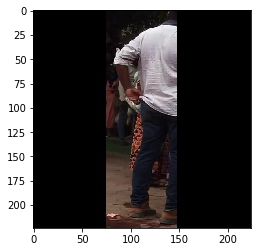

In [7]:
%matplotlib inline
from keras.preprocessing import image

im = image.load_img("./"+df.image_path[105])
plt.imshow(im)
plt.show()

In [8]:
# one hot encoding of labels

one_hot_df = pd.concat([
    df[["image_path"]],
    pd.get_dummies(df.gender, prefix="gender"),
    pd.get_dummies(df.imagequality, prefix="imagequality"),
    pd.get_dummies(df.age, prefix="age"),
    pd.get_dummies(df.weight, prefix="weight"),
    pd.get_dummies(df.carryingbag, prefix="carryingbag"),
    pd.get_dummies(df.footwear, prefix="footwear"),
    pd.get_dummies(df.emotion, prefix="emotion"),
    pd.get_dummies(df.bodypose, prefix="bodypose"),
], axis = 1)

one_hot_df.head().T

,0,1,2,3,4
image_path,resized/1.jpg,resized/2.jpg,resized/3.jpg,resized/4.jpg,resized/5.jpg
gender_female,0,1,0,0,1
gender_male,1,0,1,1,0
imagequality_Average,1,1,0,0,0
imagequality_Bad,0,0,0,0,0
imagequality_Good,0,0,1,1,1
age_15-25,0,0,0,0,0
age_25-35,0,0,0,0,0
age_35-45,1,1,0,0,1
age_45-55,0,0,1,1,0


In [9]:
one_hot_df.head()

,image_path,gender_female,gender_male,imagequality_Average,imagequality_Bad,imagequality_Good,age_15-25,age_25-35,age_35-45,age_45-55,age_55+,weight_normal-healthy,weight_over-weight,weight_slightly-overweight,weight_underweight,carryingbag_Daily/Office/Work Bag,carryingbag_Grocery/Home/Plastic Bag,carryingbag_None,footwear_CantSee,footwear_Fancy,footwear_Normal,emotion_Angry/Serious,emotion_Happy,emotion_Neutral,emotion_Sad,bodypose_Back,bodypose_Front-Frontish,bodypose_Side
0,resized/1.jpg,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0
1,resized/2.jpg,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0
2,resized/3.jpg,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0
3,resized/4.jpg,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0
4,resized/5.jpg,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,1,0


In [10]:
import keras
import numpy as np

# Label columns per attribute
_gender_cols_ = [col for col in one_hot_df.columns if col.startswith("gender")]
_imagequality_cols_ = [col for col in one_hot_df.columns if col.startswith("imagequality")]
_age_cols_ = [col for col in one_hot_df.columns if col.startswith("age")]
_weight_cols_ = [col for col in one_hot_df.columns if col.startswith("weight")]
_carryingbag_cols_ = [col for col in one_hot_df.columns if col.startswith("carryingbag")]
_footwear_cols_ = [col for col in one_hot_df.columns if col.startswith("footwear")]
_emotion_cols_ = [col for col in one_hot_df.columns if col.startswith("emotion")]
_bodypose_cols_ = [col for col in one_hot_df.columns if col.startswith("bodypose")]
print(_gender_cols_)

class PersonDataGenerator(keras.utils.Sequence):
    """Ground truth data generator"""

    
    def __init__(self, df, batch_size=32, shuffle=True, augmentation = None):
        self.df = df
        self.batch_size=batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        self.augmentation = augmentation

    'Denotes the number of batches per epoch'
    def __len__(self): 
        return int(np.floor(self.df.shape[0] / self.batch_size))

    def __getitem__(self, index):
        """fetch batched images and targets"""
        batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
        items = self.df.iloc[batch_slice]
        image = np.stack([cv2.imread(item["image_path"]) for _, item in items.iterrows()])
        if self.augmentation is not None:
          image = self.augmentation.flow(image, shuffle = False).next()
        target = {
            "gender_output": items[_gender_cols_].values,
            "image_quality_output": items[_imagequality_cols_].values,
            "age_output": items[_age_cols_].values,
            "weight_output": items[_weight_cols_].values,
            "bag_output": items[_carryingbag_cols_].values,
            "pose_output": items[_bodypose_cols_].values,
            "footwear_output": items[_footwear_cols_].values,
            "emotion_output": items[_emotion_cols_].values,
        }
        return image, target

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)


['gender_female', 'gender_male']


In [11]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(one_hot_df, test_size=0.15, random_state = 123)
train_df.shape, val_df.shape

((11537, 28), (2036, 28))

In [0]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-5
    if epoch > 30:
        lr *= 0.5e-3
    elif epoch > 35:
        lr *= 1e-3
    elif epoch > 40:
        lr *= 1e-2
    elif epoch > 45:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


In [13]:
train_df.head()

,image_path,gender_female,gender_male,imagequality_Average,imagequality_Bad,imagequality_Good,age_15-25,age_25-35,age_35-45,age_45-55,age_55+,weight_normal-healthy,weight_over-weight,weight_slightly-overweight,weight_underweight,carryingbag_Daily/Office/Work Bag,carryingbag_Grocery/Home/Plastic Bag,carryingbag_None,footwear_CantSee,footwear_Fancy,footwear_Normal,emotion_Angry/Serious,emotion_Happy,emotion_Neutral,emotion_Sad,bodypose_Back,bodypose_Front-Frontish,bodypose_Side
4828,resized/4829.jpg,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0
7983,resized/7984.jpg,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0
820,resized/821.jpg,1,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0
4865,resized/4866.jpg,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0
6751,resized/6752.jpg,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1


In [0]:
# create train and validation data generators
train_gen = PersonDataGenerator(train_df, batch_size=32, augmentation = None) #ImageDataGenerator(horizontal_flip = True, vertical_flip = True))
valid_gen = PersonDataGenerator(val_df, batch_size=64, shuffle=False)

In [15]:
# get number of output units from data
images, targets = next(iter(train_gen))
num_units = { k.split("_output")[0]:v.shape[1] for k, v in targets.items()}
num_units

{'age': 5,
 'bag': 3,
 'emotion': 4,
 'footwear': 3,
 'gender': 2,
 'image_quality': 3,
 'pose': 3,
 'weight': 4}

In [16]:
images[0].shape

(224, 224, 3)

In [0]:
# backbone = VGG16(
#     weights="imagenet", 
#     include_top=False, 
#     input_tensor=Input(shape=(224, 224, 3))
# )
visible = Input(shape=(224,224,3))

#Block 1
conv1 = Conv2D(32, kernel_size=3, activation='relu',use_bias=False)(visible) #222
conv1_bn = BatchNormalization()(conv1)
conv1_d = Dropout(0.1)(conv1_bn)

#Block 2
conv2 = Conv2D(32, kernel_size=3, activation='relu',use_bias=False)(conv1_d) #220
conv2_bn = BatchNormalization()(conv2)
conv2_d = Dropout(0.1)(conv2_bn)


pool1 = MaxPooling2D(pool_size=(2, 2))(conv2_d) #110

#Block 3
conv3 = Conv2D(64, kernel_size=3, activation='relu',use_bias=False)(pool1) #108
conv3_bn = BatchNormalization()(conv3)
conv3_d = Dropout(0.1)(conv3_bn)

pool2 = MaxPooling2D(pool_size=(2, 2))(conv3_d) #54

#Block 4
conv4 = Conv2D(64, kernel_size=3, activation='relu',use_bias=False)(pool2) #52
conv4_bn = BatchNormalization()(conv4)
conv4_d = Dropout(0.1)(conv4_bn)

pool3= MaxPooling2D(pool_size=(2, 2))(conv4_d) #26

#Block 5
conv5 = Conv2D(128, kernel_size=3, activation='relu',use_bias=False)(pool3) #24
conv5_bn = BatchNormalization()(conv5)
conv5_d = Dropout(0.1)(conv5_bn)

pool4= MaxPooling2D(pool_size=(2, 2))(conv5_d) #12


neck = Conv2D(128, kernel_size=3, activation='relu')(pool4)
# neck = MaxPooling2D(pool_size=(2, 2))(conv2)


# neck = backbone.output
neck = Flatten(name="flatten")(neck)
neck = Dense(512, activation="relu")(neck)

# Define the model


def build_tower(in_layer):
    neck = Dropout(0.1)(in_layer) #0.5 to 0.1
    neck = Dense(128, activation="relu")(neck)
    #neck = Dropout(0.1)(in_layer) #0.5 to 0.1
    neck = Dense(128, activation="relu")(neck)
    return neck


def build_head(name, in_layer):
    return Dense(
        num_units[name], activation="softmax", name=f"{name}_output"
    )(in_layer)

# heads
gender = build_head("gender", build_tower(neck))
image_quality = build_head("image_quality", build_tower(neck))
age = build_head("age", build_tower(neck))
weight = build_head("weight", build_tower(neck))
bag = build_head("bag", build_tower(neck))
footwear = build_head("footwear", build_tower(neck))
emotion = build_head("emotion", build_tower(neck))
pose = build_head("pose", build_tower(neck))


model = Model(
    inputs=visible, 
    outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion]
)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 222, 222, 32) 864         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_21 (BatchNo (None, 222, 222, 32) 128         conv2d_25[0][0]                  
__________________________________________________________________________________________________
dropout_45 (Dropout)            (None, 222, 222, 32) 0           batch_normalization_21[0][0]     
____________________________________________________________________________________________

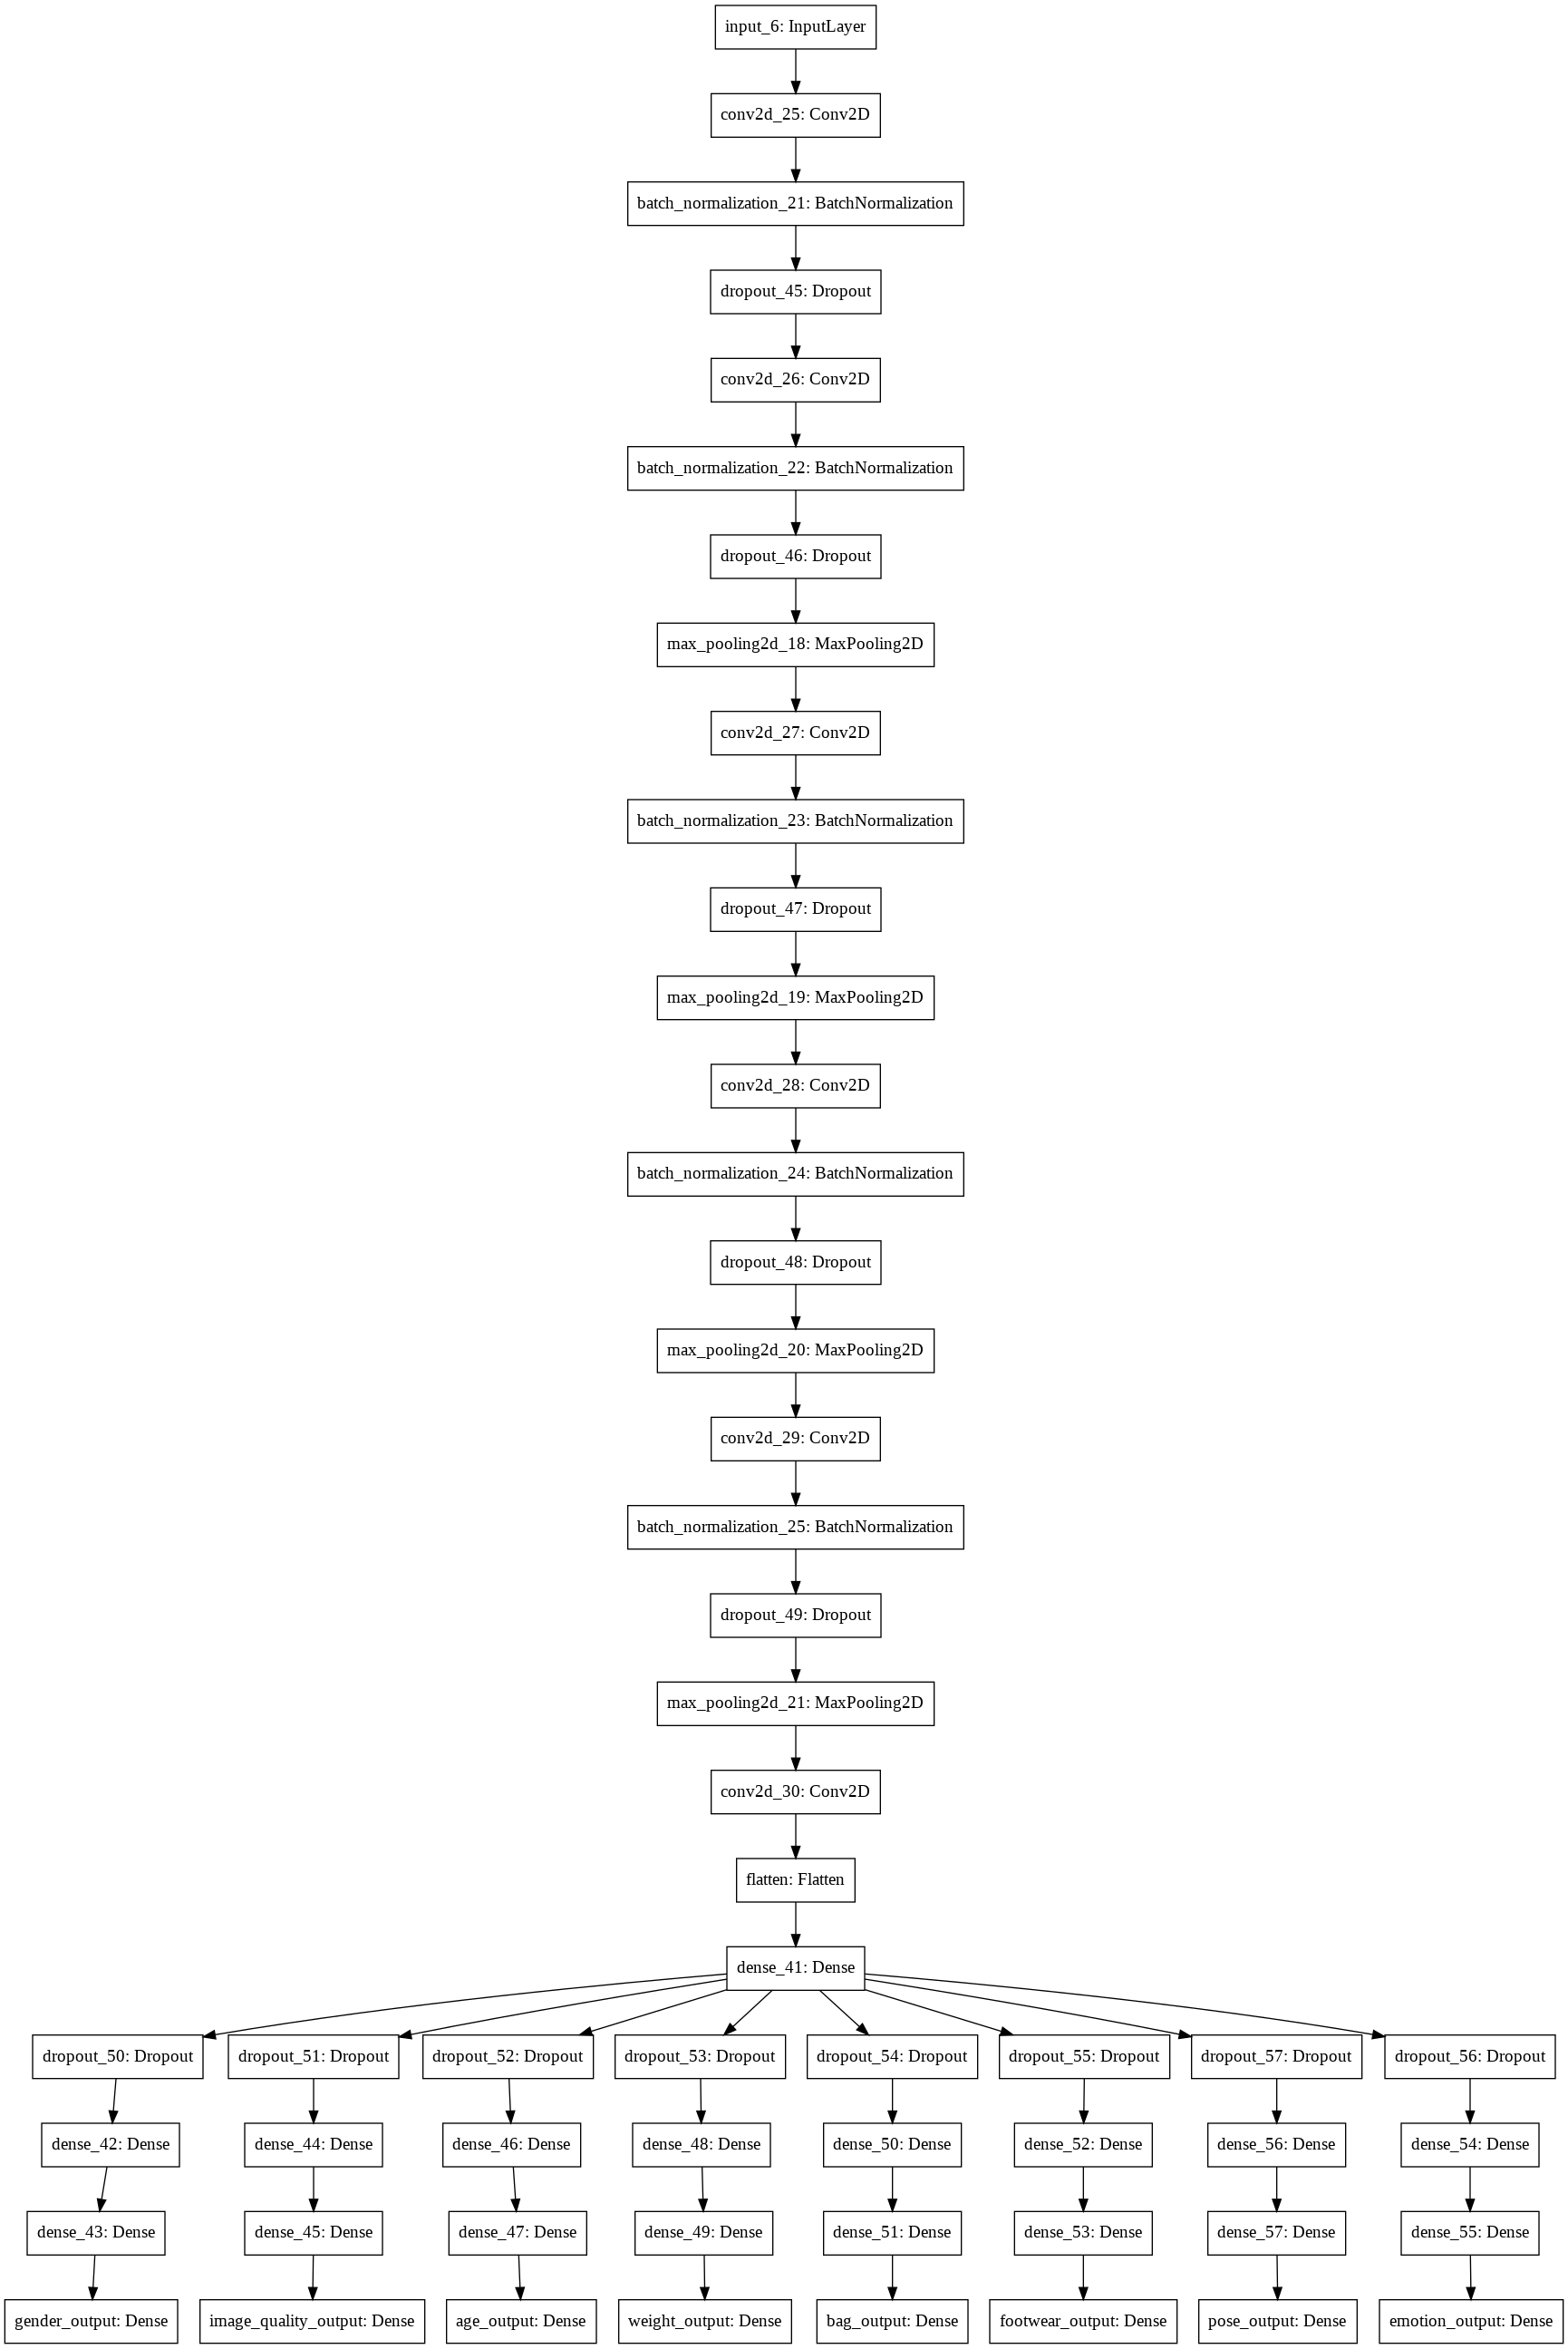

In [26]:
# summarize layers
print(model.summary())
# plot graph
plot_model(model)

In [17]:
# Load the model
model = load_model('./saved_models/trained_model.h14')










Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [0]:
losses = {
	"gender_output": "binary_crossentropy",
	"image_quality_output": "binary_crossentropy",
	"age_output": "binary_crossentropy",
	"weight_output": "binary_crossentropy",
  "bag_output" : "binary_crossentropy",
  "footwear_output" : "binary_crossentropy",
  "pose_output" : "binary_crossentropy",
  "emotion_output" : "binary_crossentropy"

}

loss_weights = {"gender_output": 0.7 , "image_quality_output": 0.5, "age_output": 0.09, "bag_output" : 0.09, "emotion_output" :0.1, "weight_output" : 0.1, "pose_output" : 0.1} #age=0.01 , bag=0.1, age=0.04(h13)
opt = SGD(lr=0.00099, momentum=0.9) #lr=0.0005(h10) , 0.0007(h11), 0.0009(h13)
model.compile(
    optimizer=opt,
    loss=losses, 
    loss_weights=loss_weights, 
    metrics=["accuracy"]
)

In [0]:
# model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=32, epochs=10)

In [32]:
# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'trained_model_resnet.h1'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

def scheduler(epoch, lr):
  return round(0.00099 * 1/(1 + 0.319 * epoch), 10) #0.0009(h13)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(scheduler, verbose=1)

# def step_decay_schedule(initial_lr=1e-3, decay_factor=0.75, step_size=10):
#     '''
#     Wrapper function to create a LearningRateScheduler with step decay schedule.
#     '''
#     def schedule(epoch):
#         return initial_lr * (decay_factor ** np.floor(epoch/step_size))
    
#     return LearningRateScheduler(schedule)

# lr_scheduler = step_decay_schedule(initial_lr=1e-5, decay_factor=0.75, step_size=2)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=1,
                               patience=4,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

# Fit the model on the batches generated by datagen.flow().
# model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
#                     validation_data=(x_test, y_test),
#                     epochs=epochs, verbose=1, workers=4,
#                     callbacks=callbacks)
model_info = model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=10, #can use 35 epochs
    verbose=1,
    callbacks=callbacks)


# model.fit_generator(
#     generator=train_gen,
#     validation_data=valid_gen,
#     use_multiprocessing=True,
#     workers=6, 
#     epochs=10,
#     verbose=1
# )

Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to 0.00099.
359/360 [============================>.] - ETA: 0s - loss: 0.1939 - gender_output_loss: 0.0038 - image_quality_output_loss: 0.0124 - age_output_loss: 0.4650 - weight_output_loss: 0.3768 - bag_output_loss: 0.4376 - footwear_output_loss: 0.0059 - pose_output_loss: 0.2586 - emotion_output_loss: 0.3442 - gender_output_acc: 0.9985 - image_quality_output_acc: 0.9970 - age_output_acc: 0.7924 - weight_output_acc: 0.8350 - bag_output_acc: 0.7973 - footwear_output_acc: 0.9987 - pose_output_acc: 0.8957 - emotion_output_acc: 0.8621

360/360 [==============================] - 103s 287ms/step - loss: 0.1939 - gender_output_loss: 0.0038 - image_quality_output_loss: 0.0124 - age_output_loss: 0.4650 - weight_output_loss: 0.3768 - bag_output_loss: 0.4377 - footwear_output_loss: 0.0059 - pose_output_loss: 0.2586 - emotion_output_loss: 0.3438 - gender_output_acc: 0.9984 - image_quality_output_acc: 0.9970 - age_output_acc: 0.7

In [0]:
model.save('./saved_models/trained_model.h15') #best model is h11 as of now

In [19]:
# Score trained model.
results = model.evaluate_generator(valid_gen, verbose=1)
dict(zip(model.metrics_names, results))

31/31 [==============================] - 739s 24s/step


{'age_output_acc': 0.7764113122417081,
 'age_output_loss': 0.49176413974454325,
 'bag_output_acc': 0.7745295916834185,
 'bag_output_loss': 0.47757232958270657,
 'emotion_output_acc': 0.8577368951612904,
 'emotion_output_loss': 0.369359040452588,
 'footwear_output_acc': 0.976982545468115,
 'footwear_output_loss': 0.07685946387749526,
 'gender_output_acc': 0.9873991935483871,
 'gender_output_loss': 0.03953302520207099,
 'image_quality_output_acc': 0.9695900717089253,
 'image_quality_output_loss': 0.08420531833243947,
 'loss': 0.35118254442368785,
 'pose_output_acc': 0.8282930216481609,
 'pose_output_loss': 0.39288611662003303,
 'weight_output_acc': 0.8245967741935484,
 'weight_output_loss': 0.41082503141895416}

**Gender Output**

dict_keys(['val_loss', 'val_gender_output_loss', 'val_image_quality_output_loss', 'val_age_output_loss', 'val_weight_output_loss', 'val_bag_output_loss', 'val_footwear_output_loss', 'val_pose_output_loss', 'val_emotion_output_loss', 'val_gender_output_acc', 'val_image_quality_output_acc', 'val_age_output_acc', 'val_weight_output_acc', 'val_bag_output_acc', 'val_footwear_output_acc', 'val_pose_output_acc', 'val_emotion_output_acc', 'loss', 'gender_output_loss', 'image_quality_output_loss', 'age_output_loss', 'weight_output_loss', 'bag_output_loss', 'footwear_output_loss', 'pose_output_loss', 'emotion_output_loss', 'gender_output_acc', 'image_quality_output_acc', 'age_output_acc', 'weight_output_acc', 'bag_output_acc', 'footwear_output_acc', 'pose_output_acc', 'emotion_output_acc', 'lr'])


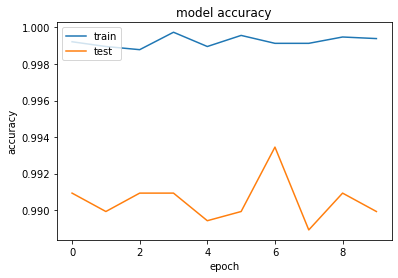

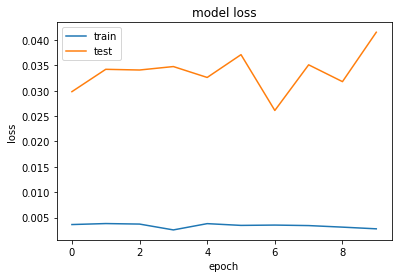

In [0]:
# list all data in history
print(model_info.history.keys())
# summarize history for accuracy
plt.plot(model_info.history['gender_output_acc'])
plt.plot(model_info.history['val_gender_output_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_info.history['gender_output_loss'])
plt.plot(model_info.history['val_gender_output_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Image Quality Output**

dict_keys(['val_loss', 'val_gender_output_loss', 'val_image_quality_output_loss', 'val_age_output_loss', 'val_weight_output_loss', 'val_bag_output_loss', 'val_footwear_output_loss', 'val_pose_output_loss', 'val_emotion_output_loss', 'val_gender_output_acc', 'val_image_quality_output_acc', 'val_age_output_acc', 'val_weight_output_acc', 'val_bag_output_acc', 'val_footwear_output_acc', 'val_pose_output_acc', 'val_emotion_output_acc', 'loss', 'gender_output_loss', 'image_quality_output_loss', 'age_output_loss', 'weight_output_loss', 'bag_output_loss', 'footwear_output_loss', 'pose_output_loss', 'emotion_output_loss', 'gender_output_acc', 'image_quality_output_acc', 'age_output_acc', 'weight_output_acc', 'bag_output_acc', 'footwear_output_acc', 'pose_output_acc', 'emotion_output_acc', 'lr'])


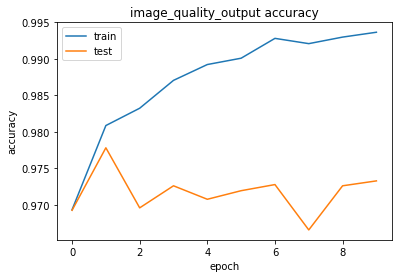

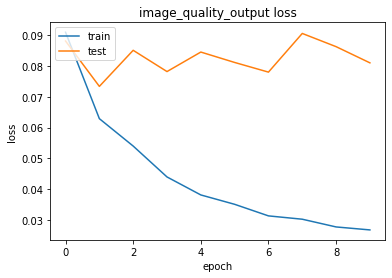

In [0]:
# list all data in history
print(model_info.history.keys())
# summarize history for accuracy
plt.plot(model_info.history['image_quality_output_acc'])
plt.plot(model_info.history['val_image_quality_output_acc'])
plt.title('image_quality_output accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_info.history['image_quality_output_loss'])
plt.plot(model_info.history['val_image_quality_output_loss'])
plt.title('image_quality_output loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Age Output**

dict_keys(['val_loss', 'val_gender_output_loss', 'val_image_quality_output_loss', 'val_age_output_loss', 'val_weight_output_loss', 'val_bag_output_loss', 'val_footwear_output_loss', 'val_pose_output_loss', 'val_emotion_output_loss', 'val_gender_output_acc', 'val_image_quality_output_acc', 'val_age_output_acc', 'val_weight_output_acc', 'val_bag_output_acc', 'val_footwear_output_acc', 'val_pose_output_acc', 'val_emotion_output_acc', 'loss', 'gender_output_loss', 'image_quality_output_loss', 'age_output_loss', 'weight_output_loss', 'bag_output_loss', 'footwear_output_loss', 'pose_output_loss', 'emotion_output_loss', 'gender_output_acc', 'image_quality_output_acc', 'age_output_acc', 'weight_output_acc', 'bag_output_acc', 'footwear_output_acc', 'pose_output_acc', 'emotion_output_acc', 'lr'])


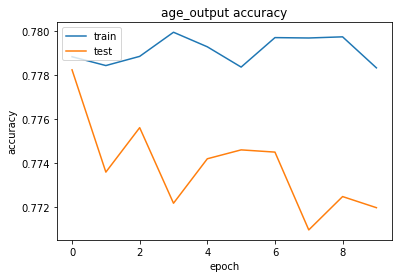

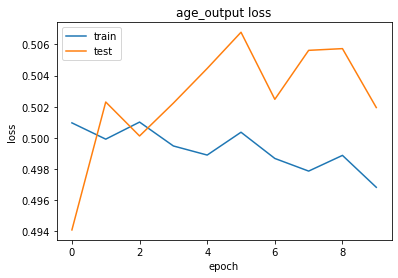

In [0]:
# list all data in history
print(model_info.history.keys())
# summarize history for accuracy
plt.plot(model_info.history['age_output_acc'])
plt.plot(model_info.history['val_age_output_acc'])
plt.title('age_output accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_info.history['age_output_loss'])
plt.plot(model_info.history['val_age_output_loss'])
plt.title('age_output loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Weight Output**

dict_keys(['val_loss', 'val_gender_output_loss', 'val_image_quality_output_loss', 'val_age_output_loss', 'val_weight_output_loss', 'val_bag_output_loss', 'val_footwear_output_loss', 'val_pose_output_loss', 'val_emotion_output_loss', 'val_gender_output_acc', 'val_image_quality_output_acc', 'val_age_output_acc', 'val_weight_output_acc', 'val_bag_output_acc', 'val_footwear_output_acc', 'val_pose_output_acc', 'val_emotion_output_acc', 'loss', 'gender_output_loss', 'image_quality_output_loss', 'age_output_loss', 'weight_output_loss', 'bag_output_loss', 'footwear_output_loss', 'pose_output_loss', 'emotion_output_loss', 'gender_output_acc', 'image_quality_output_acc', 'age_output_acc', 'weight_output_acc', 'bag_output_acc', 'footwear_output_acc', 'pose_output_acc', 'emotion_output_acc', 'lr'])


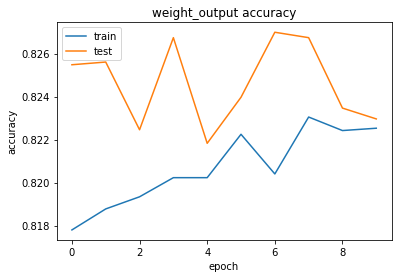

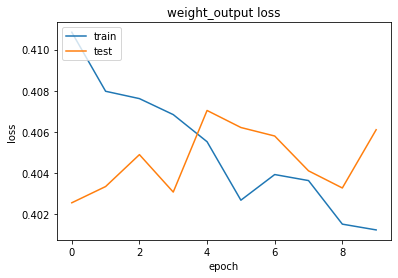

In [0]:
# list all data in history
print(model_info.history.keys())
# summarize history for accuracy
plt.plot(model_info.history['weight_output_acc'])
plt.plot(model_info.history['val_weight_output_acc'])
plt.title('weight_output accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_info.history['weight_output_loss'])
plt.plot(model_info.history['val_weight_output_loss'])
plt.title('weight_output loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Bag Output**

dict_keys(['val_loss', 'val_gender_output_loss', 'val_image_quality_output_loss', 'val_age_output_loss', 'val_weight_output_loss', 'val_bag_output_loss', 'val_footwear_output_loss', 'val_pose_output_loss', 'val_emotion_output_loss', 'val_gender_output_acc', 'val_image_quality_output_acc', 'val_age_output_acc', 'val_weight_output_acc', 'val_bag_output_acc', 'val_footwear_output_acc', 'val_pose_output_acc', 'val_emotion_output_acc', 'loss', 'gender_output_loss', 'image_quality_output_loss', 'age_output_loss', 'weight_output_loss', 'bag_output_loss', 'footwear_output_loss', 'pose_output_loss', 'emotion_output_loss', 'gender_output_acc', 'image_quality_output_acc', 'age_output_acc', 'weight_output_acc', 'bag_output_acc', 'footwear_output_acc', 'pose_output_acc', 'emotion_output_acc', 'lr'])


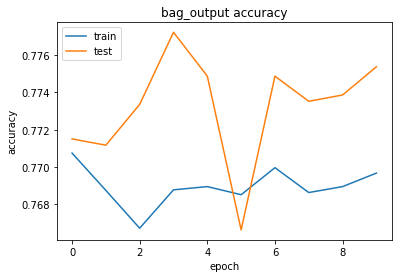

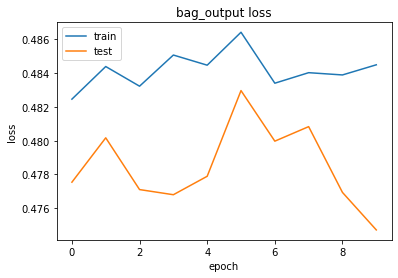

In [0]:
# list all data in history
print(model_info.history.keys())
# summarize history for accuracy
plt.plot(model_info.history['bag_output_acc'])
plt.plot(model_info.history['val_bag_output_acc'])
plt.title('bag_output accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_info.history['bag_output_loss'])
plt.plot(model_info.history['val_bag_output_loss'])
plt.title('bag_output loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Footwear Output**

dict_keys(['val_loss', 'val_gender_output_loss', 'val_image_quality_output_loss', 'val_age_output_loss', 'val_weight_output_loss', 'val_bag_output_loss', 'val_footwear_output_loss', 'val_pose_output_loss', 'val_emotion_output_loss', 'val_gender_output_acc', 'val_image_quality_output_acc', 'val_age_output_acc', 'val_weight_output_acc', 'val_bag_output_acc', 'val_footwear_output_acc', 'val_pose_output_acc', 'val_emotion_output_acc', 'loss', 'gender_output_loss', 'image_quality_output_loss', 'age_output_loss', 'weight_output_loss', 'bag_output_loss', 'footwear_output_loss', 'pose_output_loss', 'emotion_output_loss', 'gender_output_acc', 'image_quality_output_acc', 'age_output_acc', 'weight_output_acc', 'bag_output_acc', 'footwear_output_acc', 'pose_output_acc', 'emotion_output_acc', 'lr'])


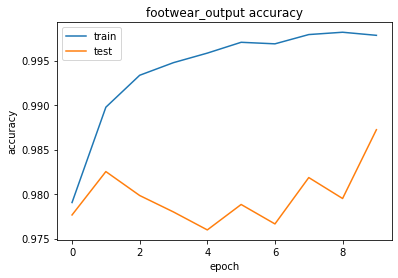

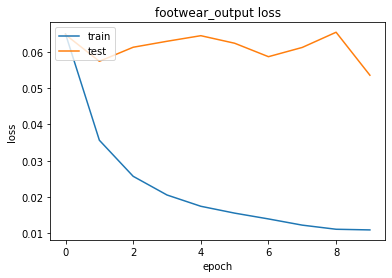

In [0]:
# list all data in history
print(model_info.history.keys())
# summarize history for accuracy
plt.plot(model_info.history['footwear_output_acc'])
plt.plot(model_info.history['val_footwear_output_acc'])
plt.title('footwear_output accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_info.history['footwear_output_loss'])
plt.plot(model_info.history['val_footwear_output_loss'])
plt.title('footwear_output loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Pose Output**

dict_keys(['val_loss', 'val_gender_output_loss', 'val_image_quality_output_loss', 'val_age_output_loss', 'val_weight_output_loss', 'val_bag_output_loss', 'val_footwear_output_loss', 'val_pose_output_loss', 'val_emotion_output_loss', 'val_gender_output_acc', 'val_image_quality_output_acc', 'val_age_output_acc', 'val_weight_output_acc', 'val_bag_output_acc', 'val_footwear_output_acc', 'val_pose_output_acc', 'val_emotion_output_acc', 'loss', 'gender_output_loss', 'image_quality_output_loss', 'age_output_loss', 'weight_output_loss', 'bag_output_loss', 'footwear_output_loss', 'pose_output_loss', 'emotion_output_loss', 'gender_output_acc', 'image_quality_output_acc', 'age_output_acc', 'weight_output_acc', 'bag_output_acc', 'footwear_output_acc', 'pose_output_acc', 'emotion_output_acc', 'lr'])


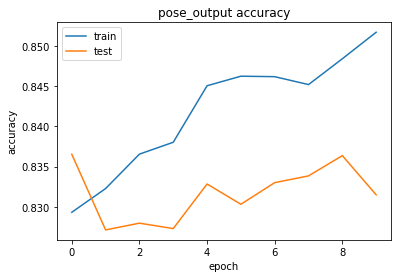

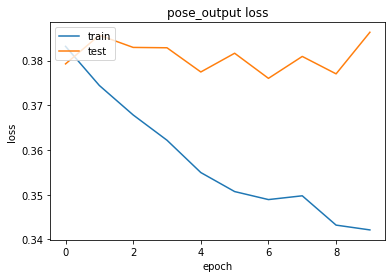

In [0]:
# list all data in history
print(model_info.history.keys())
# summarize history for accuracy
plt.plot(model_info.history['pose_output_acc'])
plt.plot(model_info.history['val_pose_output_acc'])
plt.title('pose_output accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_info.history['pose_output_loss'])
plt.plot(model_info.history['val_pose_output_loss'])
plt.title('pose_output loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Emotion Output**

dict_keys(['val_loss', 'val_gender_output_loss', 'val_image_quality_output_loss', 'val_age_output_loss', 'val_weight_output_loss', 'val_bag_output_loss', 'val_footwear_output_loss', 'val_pose_output_loss', 'val_emotion_output_loss', 'val_gender_output_acc', 'val_image_quality_output_acc', 'val_age_output_acc', 'val_weight_output_acc', 'val_bag_output_acc', 'val_footwear_output_acc', 'val_pose_output_acc', 'val_emotion_output_acc', 'loss', 'gender_output_loss', 'image_quality_output_loss', 'age_output_loss', 'weight_output_loss', 'bag_output_loss', 'footwear_output_loss', 'pose_output_loss', 'emotion_output_loss', 'gender_output_acc', 'image_quality_output_acc', 'age_output_acc', 'weight_output_acc', 'bag_output_acc', 'footwear_output_acc', 'pose_output_acc', 'emotion_output_acc', 'lr'])


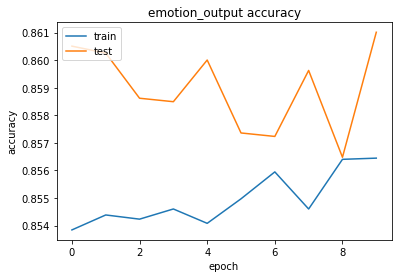

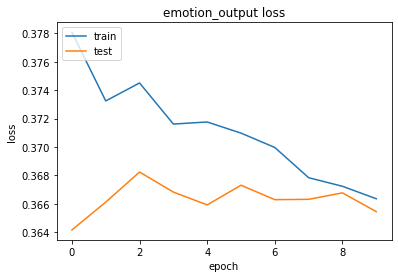

In [0]:
# list all data in history
print(model_info.history.keys())
# summarize history for accuracy
plt.plot(model_info.history['emotion_output_acc'])
plt.plot(model_info.history['val_emotion_output_acc'])
plt.title('emotion_output accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_info.history['emotion_output_loss'])
plt.plot(model_info.history['val_emotion_output_loss'])
plt.title('emotion_output loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()